### Method 3: ExplainSumm by Summarize Quality

In [122]:
import time
import shap
import optuna 

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.explainability import ExplainSumm
from src.data_visualization import visualize_metrics
from src.utils import train_test_split_comparision

from data.policy_data import policy_dict

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# 1. Load segmented comparisons
df = pd.read_csv("data\segmentation\comparisons_segmentation.csv")

# 2. Non-features definition
comparison_columns = [
    "worker",
    "batch",
    "split",
    "id",
    "source",
    "subsource",
    "title",
    "text",
    "summary_0",
    "policy_0",
    "note_0",
    "summary_1",
    "policy_1",
    "note_1",
    "confidence",
    "ref_summary",
    "choice",
]

# 3. Target
target = ["choice"]

In [4]:
df.groupby("Quality").count()

,worker,batch,split,id,source,subsource,title,text,summary_0,policy_0,note_0,summary_1,policy_1,note_1,confidence,choice,ref_summary,m0_rouge_1_f,m0_rouge_2_f,m0_rouge_l_f,m1_rouge_1_f,m1_rouge_2_f,m1_rouge_l_f,m0_bleu,m1_bleu,m0_flesch_reading_ease,m0_syllable_count,m0_lexicon_count,m0_sentence_count,m0_char_count,m0_letter_count,m0_polysyllab_count,m0_monosyllab_count,m1_flesch_reading_ease,m1_syllable_count,m1_lexicon_count,m1_sentence_count,m1_char_count,m1_letter_count,m1_polysyllab_count,m1_monosyllab_count,m0_compression_ratio,m0_jaccard_similarity_1,m0_jaccard_similarity_2,m1_compression_ratio,m1_jaccard_similarity_1,m1_jaccard_similarity_2,m0_text_summary_xfmr_similarity,m1_text_summary_xfmr_similarity,m0_ref_summary_xfmr_similarity,m1_ref_summary_xfmr_similarity
Quality,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
High,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4529,4548,4548,4529,4548,4548,3966,3966,3966,3966,3966,3966,3966,3966,3966,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,3966,3966
Low,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,31873,42928,42928,31852,19020,42928,35197,35197,35197,35197,35197,35197,35197,35197,35197,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,42928,35197,35197
Medium,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,25831,27517,27517,25738,27517,27517,15347,15347,15347,15347,15347,15347,15347,15347,15347,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,27517,15347,15347


Reducing dataset memory...
Mem. usage decreased to  8.15 Mb (52.2% reduction)


[I 2023-07-21 15:41:17,952] A new study created in memory with name: no-name-73db4e56-0a49-4364-a437-ad9de44085bf
[I 2023-07-21 15:41:21,419] Trial 0 finished with value: 0.37459256395748514 and parameters: {'lambda': 0.36815010771813, 'alpha': 0.00016610764958089586, 'subsample': 0.6704012002834107, 'colsample_bytree': 0.9518792256903943, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.013957451347857319, 'gamma': 1.2434432188847048e-09}. Best is trial 0 with value: 0.37459256395748514.
[I 2023-07-21 15:41:22,122] Trial 1 finished with value: 0.38130422336820696 and parameters: {'lambda': 0.4699777011436602, 'alpha': 0.00427526968266049, 'subsample': 0.5874986402651614, 'colsample_bytree': 0.7257065174612147, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.011524061474026612, 'gamma': 4.554637309515168e-06}. Best is trial 0 with value: 0.37459256395748514.
[I 2023-07-21 15:41:23,037] Trial 2 finished with value: 0.3798012579166195 and parameters: {'lambda': 0.3191819718893117, 'alpha'

[I 2023-07-21 15:41:55,909] Trial 21 finished with value: 0.376947381465507 and parameters: {'lambda': 0.8189487466011661, 'alpha': 2.562731150880116e-06, 'subsample': 0.7526237744131458, 'colsample_bytree': 0.5212377089856426, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.019165000262967375, 'gamma': 5.269406655678252e-07}. Best is trial 17 with value: 0.37351953831653484.
[I 2023-07-21 15:41:58,679] Trial 22 finished with value: 0.3728147033766338 and parameters: {'lambda': 0.6081728785209186, 'alpha': 7.067565237074352e-07, 'subsample': 0.8376766718934449, 'colsample_bytree': 0.3739333761413418, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03206157776169065, 'gamma': 8.732139696282205e-08}. Best is trial 22 with value: 0.3728147033766338.
[I 2023-07-21 15:41:59,501] Trial 23 finished with value: 0.38016921188817865 and parameters: {'lambda': 0.6616247083789057, 'alpha': 5.0870353966956e-07, 'subsample': 0.8383942781698586, 'colsample_bytree': 0.35969042039726007, 'max_depth': 3

[I 2023-07-21 15:42:39,085] Trial 42 finished with value: 0.3732628273441535 and parameters: {'lambda': 0.9086241653167446, 'alpha': 1.4358272261122797e-06, 'subsample': 0.5003069620336315, 'colsample_bytree': 0.38193102249211935, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.030150911747276327, 'gamma': 2.052479079066602e-08}. Best is trial 38 with value: 0.372364231192061.
[I 2023-07-21 15:42:43,674] Trial 43 finished with value: 0.3718043574887752 and parameters: {'lambda': 0.9305108724467219, 'alpha': 3.5303300810874215e-06, 'subsample': 0.5736423843203114, 'colsample_bytree': 0.3294774257540161, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.02387519436581379, 'gamma': 1.9675055371309687e-08}. Best is trial 43 with value: 0.3718043574887752.
[I 2023-07-21 15:42:46,383] Trial 44 finished with value: 0.37629195781691765 and parameters: {'lambda': 0.9447142957218659, 'alpha': 3.140324535288094e-06, 'subsample': 0.6157445576039765, 'colsample_bytree': 0.3264726028034439, 'max_depth

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 62.47 %
Precision: 61.74 %
Recall: 63.09 %
F1 Score: 62.41 %
ROC AUC: 62.48 %


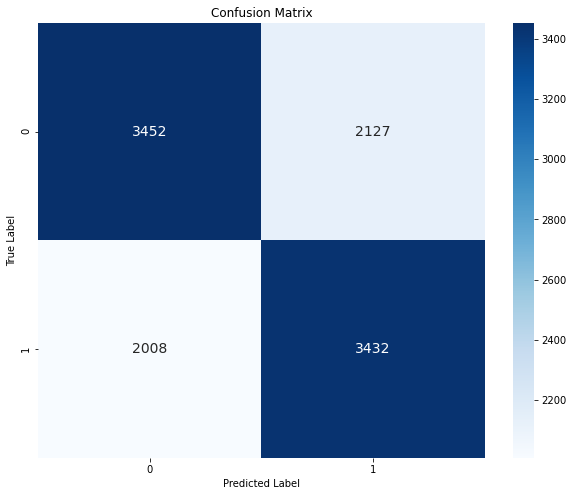

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


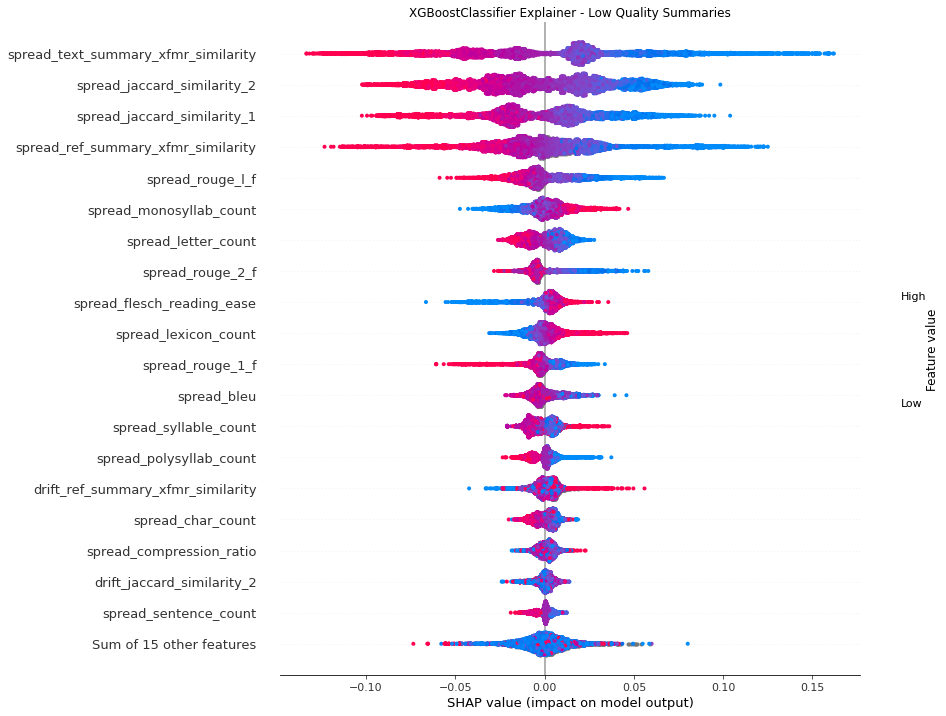

In [5]:
# SummXAI
SummXAI_low = ExplainSumm(
    df=df[df["Quality"] == "Low"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_low.metrics)

# Get shap values
explainer_low = shap.TreeExplainer(SummXAI_low.model)
shap_values_low = explainer_low(SummXAI_low.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_low, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - Low Quality Summaries")

# Show the plot
plt.show()

Reducing dataset memory...
Mem. usage decreased to  5.22 Mb (52.2% reduction)


[I 2023-07-21 15:43:10,430] A new study created in memory with name: no-name-c1dbca4b-75a5-4fe1-a3b5-eb5a0860f040
[I 2023-07-21 15:43:12,304] Trial 0 finished with value: 0.40317773063736384 and parameters: {'lambda': 0.4075751262375626, 'alpha': 1.0289490541092621e-07, 'subsample': 0.754621460031166, 'colsample_bytree': 0.4704743531944734, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.10720545722640286, 'gamma': 1.9353771027724995e-07}. Best is trial 0 with value: 0.40317773063736384.
[I 2023-07-21 15:43:14,698] Trial 1 finished with value: 0.4082683360958982 and parameters: {'lambda': 0.49782647961036713, 'alpha': 1.4470136597251348e-05, 'subsample': 0.5311031926549593, 'colsample_bytree': 0.6020805169145667, 'max_depth': 8, 'min_child_weight': 1, 'eta': 0.03238516293151984, 'gamma': 1.2296782663181598e-08}. Best is trial 0 with value: 0.40317773063736384.
[I 2023-07-21 15:43:15,253] Trial 2 finished with value: 0.4059272915157532 and parameters: {'lambda': 0.9349380571920441, 'alp

[I 2023-07-21 15:43:33,929] Trial 21 finished with value: 0.4029231553400822 and parameters: {'lambda': 0.25762850756371863, 'alpha': 3.4142662900150783e-07, 'subsample': 0.5023321323854331, 'colsample_bytree': 0.3545099285111243, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.08357027076334236, 'gamma': 4.028495344374429e-06}. Best is trial 13 with value: 0.40154674079172165.
[I 2023-07-21 15:43:34,992] Trial 22 finished with value: 0.4060187845208051 and parameters: {'lambda': 0.2990379735765255, 'alpha': 1.4921390599278028e-06, 'subsample': 0.5653759917671751, 'colsample_bytree': 0.4320381986955808, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.07436128306357244, 'gamma': 6.412937307144965e-05}. Best is trial 13 with value: 0.40154674079172165.
[I 2023-07-21 15:43:35,847] Trial 23 finished with value: 0.40168474664708026 and parameters: {'lambda': 0.27631906182877386, 'alpha': 2.4804670658163907e-07, 'subsample': 0.5004719830968017, 'colsample_bytree': 0.3288734972608518, 'max_de

[I 2023-07-21 15:44:11,595] Trial 42 finished with value: 0.3996521503941235 and parameters: {'lambda': 0.42670254294747634, 'alpha': 1.053580525039302e-08, 'subsample': 0.5333740306884032, 'colsample_bytree': 0.4802768955292308, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.03185708661651089, 'gamma': 4.9983975015603434e-08}. Best is trial 42 with value: 0.3996521503941235.
[I 2023-07-21 15:44:13,494] Trial 43 finished with value: 0.401462112699493 and parameters: {'lambda': 0.42426015680312074, 'alpha': 2.2123905419566282e-08, 'subsample': 0.6045668029671178, 'colsample_bytree': 0.5118216386933248, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.029714610966204855, 'gamma': 4.658470145033808e-08}. Best is trial 42 with value: 0.3996521503941235.
[I 2023-07-21 15:44:14,629] Trial 44 finished with value: 0.4046672488021052 and parameters: {'lambda': 0.37894725777481075, 'alpha': 7.902279870523287e-08, 'subsample': 0.5262408957577605, 'colsample_bytree': 0.5592363523449477, 'max_dept

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 60.44 %
Precision: 61.19 %
Recall: 63.26 %
F1 Score: 62.21 %
ROC AUC: 60.36 %


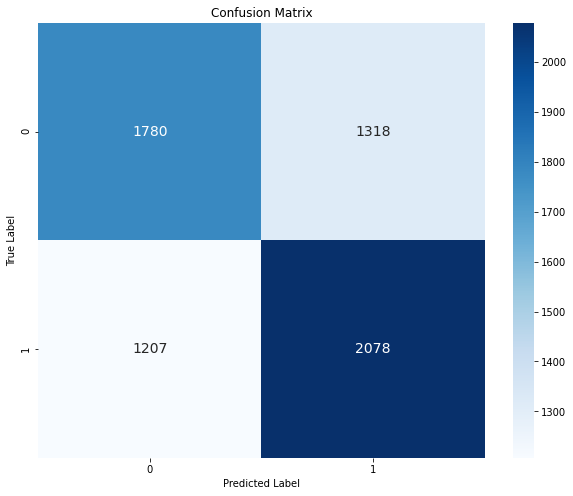

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


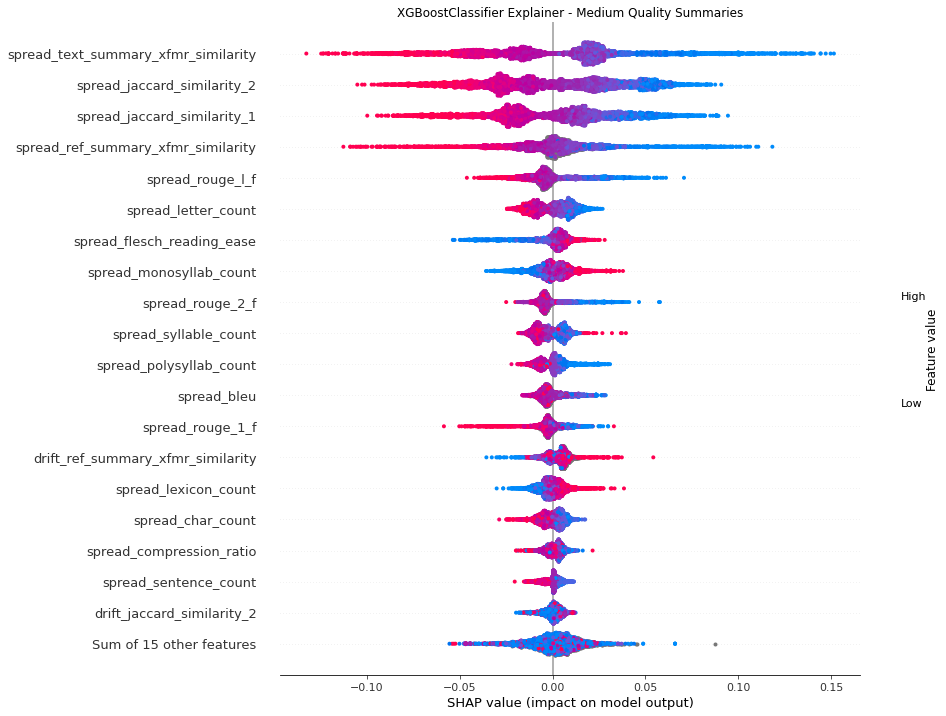

In [6]:
# SummXAI
SummXAI_medium = ExplainSumm(
    df=df[df["Quality"] == "Medium"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_medium.metrics)

# Get shap values
explainer_medium = shap.TreeExplainer(SummXAI_medium.model)
shap_values_medium = explainer_low(SummXAI_medium.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_medium, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - Medium Quality Summaries")

# Show the plot
plt.show()

[I 2023-07-21 15:44:27,461] A new study created in memory with name: no-name-a7fbaa7a-0329-44ea-b458-5f1e8f42673f


Reducing dataset memory...
Mem. usage decreased to  0.86 Mb (52.2% reduction)


[I 2023-07-21 15:44:28,659] Trial 0 finished with value: 0.45374182912635785 and parameters: {'lambda': 0.4085421447302661, 'alpha': 5.8524035860121317e-08, 'subsample': 0.9243454777663589, 'colsample_bytree': 0.5232952989308509, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.12738069092647755, 'gamma': 6.526190532874979e-07}. Best is trial 0 with value: 0.45374182912635785.
[I 2023-07-21 15:44:29,802] Trial 1 finished with value: 0.4244840895934618 and parameters: {'lambda': 0.9903653841796662, 'alpha': 1.2836699543439284e-07, 'subsample': 0.5702458438305693, 'colsample_bytree': 0.2792420775756051, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.013196375030306965, 'gamma': 0.0014318007050601836}. Best is trial 1 with value: 0.4244840895934618.
[I 2023-07-21 15:44:31,282] Trial 2 finished with value: 0.4286680749494871 and parameters: {'lambda': 0.8686564032048116, 'alpha': 5.361820868032219e-07, 'subsample': 0.6230639940300597, 'colsample_bytree': 0.2619049355941807, 'max_depth': 5,

[I 2023-07-21 15:44:50,002] Trial 21 finished with value: 0.4193507941040064 and parameters: {'lambda': 0.31373053309797355, 'alpha': 0.009215568459843091, 'subsample': 0.8550407846967896, 'colsample_bytree': 0.681430786906573, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.040146743682661766, 'gamma': 4.1797230308179026e-07}. Best is trial 20 with value: 0.4183457637181311.
[I 2023-07-21 15:44:50,729] Trial 22 finished with value: 0.42291428576587736 and parameters: {'lambda': 0.32554363218027077, 'alpha': 0.0023268896261716076, 'subsample': 0.8772172906632013, 'colsample_bytree': 0.556959950806463, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.025373958117568846, 'gamma': 1.8192282710593244e-07}. Best is trial 20 with value: 0.4183457637181311.
[I 2023-07-21 15:44:51,521] Trial 23 finished with value: 0.4193287464186629 and parameters: {'lambda': 0.25219879912238524, 'alpha': 0.0003660991996073532, 'subsample': 0.7962592795666257, 'colsample_bytree': 0.705048506774232, 'max_depth'

[I 2023-07-21 15:45:08,979] Trial 42 finished with value: 0.4179757719038116 and parameters: {'lambda': 0.3680390471181887, 'alpha': 0.0038137003311152153, 'subsample': 0.8733965828621257, 'colsample_bytree': 0.6193014270638075, 'max_depth': 3, 'min_child_weight': 1, 'eta': 0.0444334858222603, 'gamma': 8.698501348036721e-08}. Best is trial 33 with value: 0.4123901449245129.
[I 2023-07-21 15:45:09,683] Trial 43 finished with value: 0.4216258243165438 and parameters: {'lambda': 0.4024354284905963, 'alpha': 0.0004503860041690562, 'subsample': 0.9392167620554682, 'colsample_bytree': 0.6532143562414717, 'max_depth': 3, 'min_child_weight': 1, 'eta': 0.04371447276520324, 'gamma': 4.957252829199599e-07}. Best is trial 33 with value: 0.4123901449245129.
[I 2023-07-21 15:45:10,742] Trial 44 finished with value: 0.42300856008215443 and parameters: {'lambda': 0.44469038745440587, 'alpha': 0.0014107274349363797, 'subsample': 0.8999421992854751, 'colsample_bytree': 0.625064495872467, 'max_depth': 4,

Training model...
Generating predictions...
Calculate classification metrics...
Accuracy: 61.23 %
Precision: 65.38 %
Recall: 61.28 %
F1 Score: 63.26 %
ROC AUC: 61.22 %


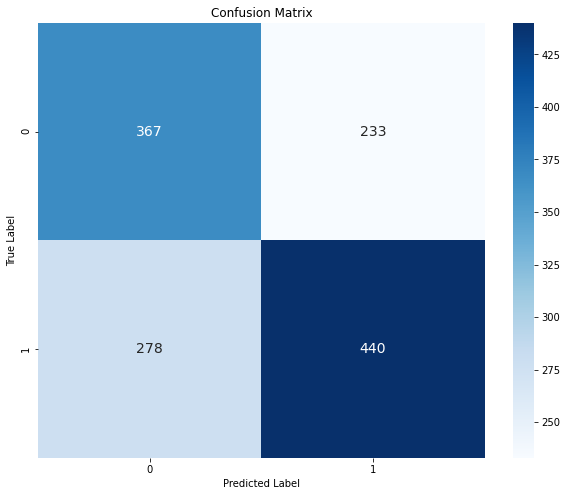

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


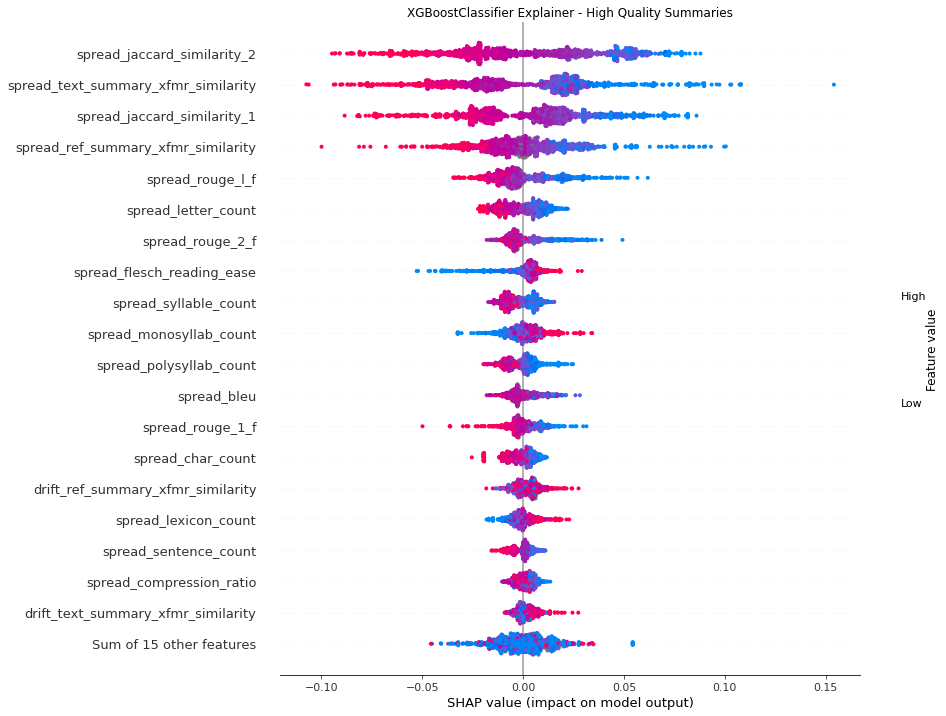

In [7]:
# SummXAI
SummXAI_high = ExplainSumm(
    df=df[df["Quality"] == "High"].drop("Quality", axis=1),
    target=target, 
    non_features=comparison_columns,
    n_trials=50,
    n_boost_round=250,
)

# Metrics
visualize_metrics(SummXAI_high.metrics)

# Get shap values
explainer_high = shap.TreeExplainer(SummXAI_high.model)
shap_values_high = explainer_low(SummXAI_high.X_test)

# Beeswarm plot
shap.plots.beeswarm(shap_values_high, max_display=20, show=False, plot_size=(13, 12))
plt.title("XGBoostClassifier Explainer - High Quality Summaries")

# Show the plot
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


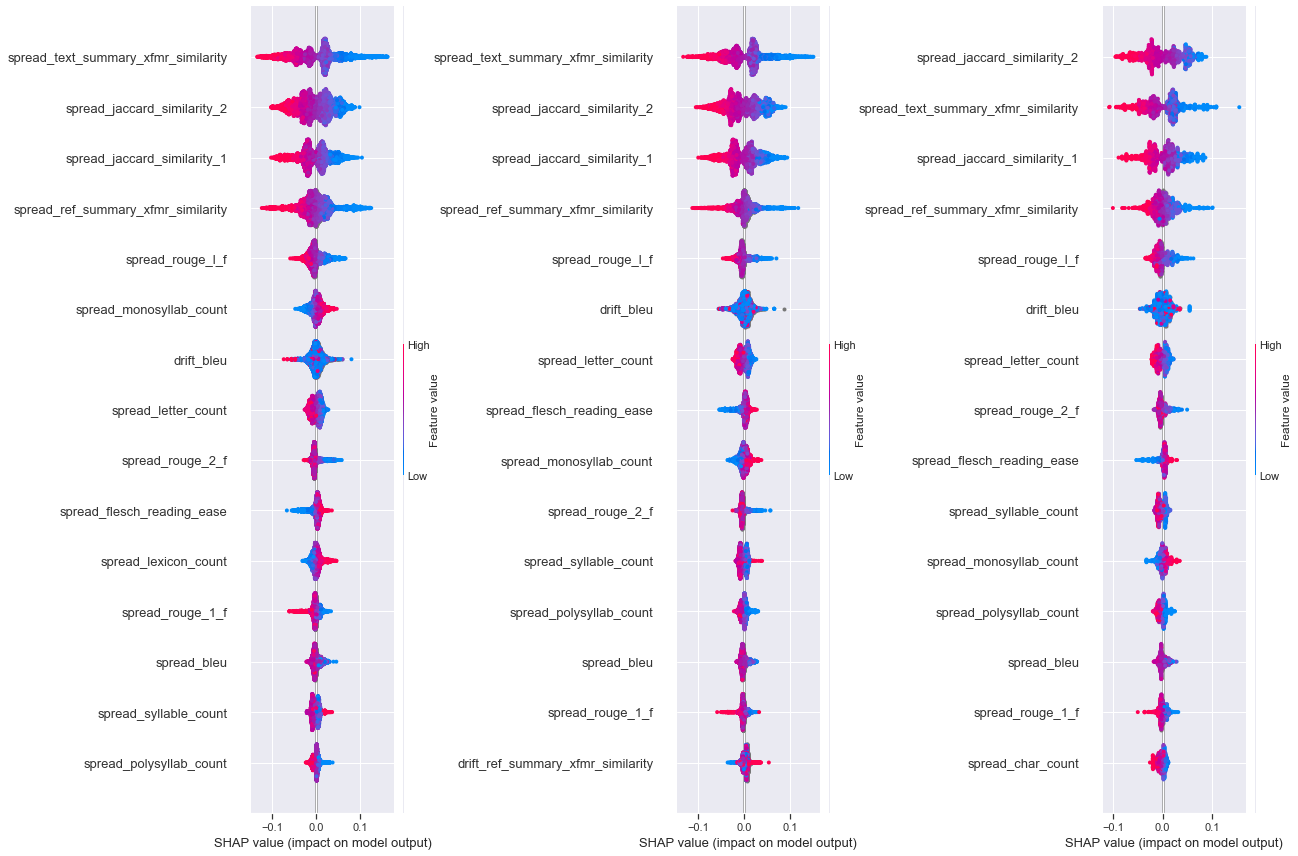

In [123]:
plt.figure(figsize=(18, 12))

plt.subplot(1,3,1)
shap.summary_plot(shap_values_low, SummXAI_low.X_test,  max_display=15, plot_size=None, show=False)

plt.subplot(1,3,2)
shap.summary_plot(shap_values_medium, SummXAI_medium.X_test,  max_display=15, plot_size=None, show=False)

plt.subplot(1,3,3)
shap.summary_plot(shap_values_high, SummXAI_high.X_test,  max_display=15, plot_size=None, show=False)

plt.tight_layout()
plt.show()

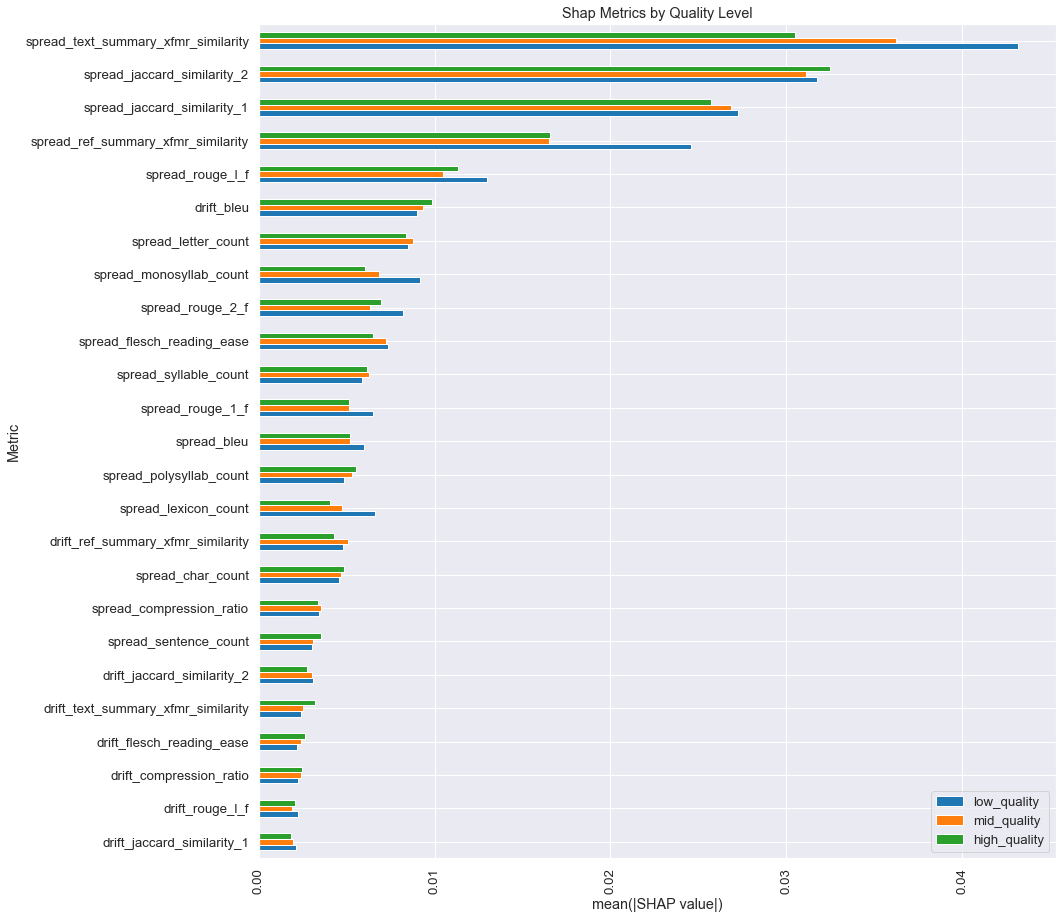

In [124]:
shap_df = pd.concat(
    [
        pd.DataFrame(shap_values_low.values, columns=SummXAI_low.X_test.columns).abs().mean().rename("low_quality"),
        pd.DataFrame(shap_values_medium.values, columns=SummXAI_medium.X_test.columns).abs().mean().rename("mid_quality"),
        pd.DataFrame(shap_values_high.values, columns=SummXAI_high.X_test.columns).abs().mean().rename("high_quality"),
    ], 
    axis=1
)

shap_df["mean"] = shap_df.mean(axis=1)
shap_df.sort_values("mean", inplace=True)
shap_df.drop("mean", axis=1, inplace=True)

sns.set_palette(sns.color_palette("tab10"))
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

shap_df.tail(25).plot(kind='barh', stacked=False, figsize=(15,13))
plt.title('Shap Metrics by Quality Level')
plt.xlabel("mean(|SHAP value|)")
plt.ylabel("Metric")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [125]:
def plot_shap_dependence(metric, X_low, X_medium, X_high, shap_values_low, shap_values_medium, shap_values_high):
    # Ajusta nrows, ncols para que se ajusten a todas tus columnas
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

    # Plot para los resumenes de baja calidad
    shap.dependence_plot(metric, shap_values_low, X_low, ax=axes[0], interaction_index=metric, xmin="percentile(1)", xmax="percentile(99)", show=False, title="Low Quality")

    # Plot para los resumenes de calidad media
    shap.dependence_plot(metric, shap_values_medium, X_medium, ax=axes[1], interaction_index=metric, xmin="percentile(1)", xmax="percentile(99)", show=False, title="Mid Quality")

    # Plot para los resumenes de alta calidad
    shap.dependence_plot(metric, shap_values_high, X_high, ax=axes[2], interaction_index=metric, xmin="percentile(1)", xmax="percentile(99)", show=False, title="High Quality")

    # Muestra todos los plots
    plt.show()

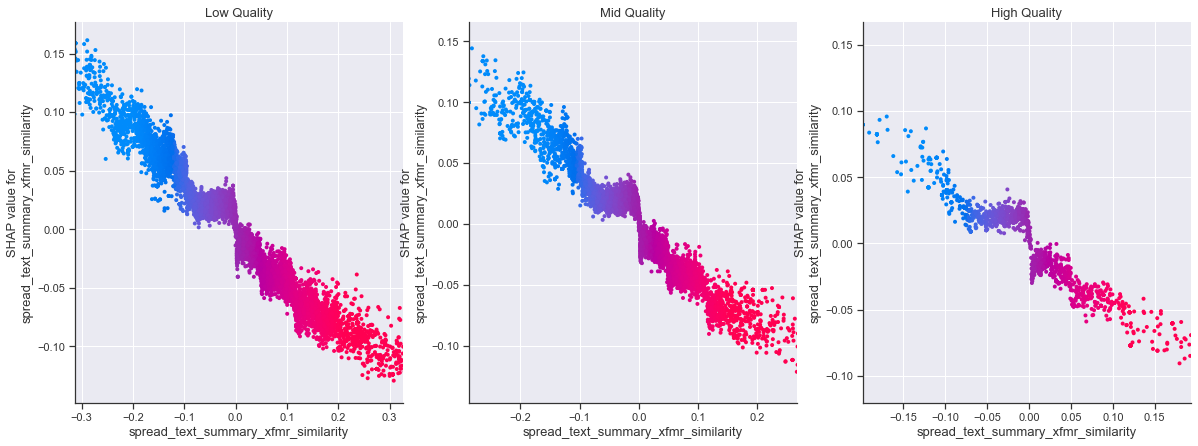

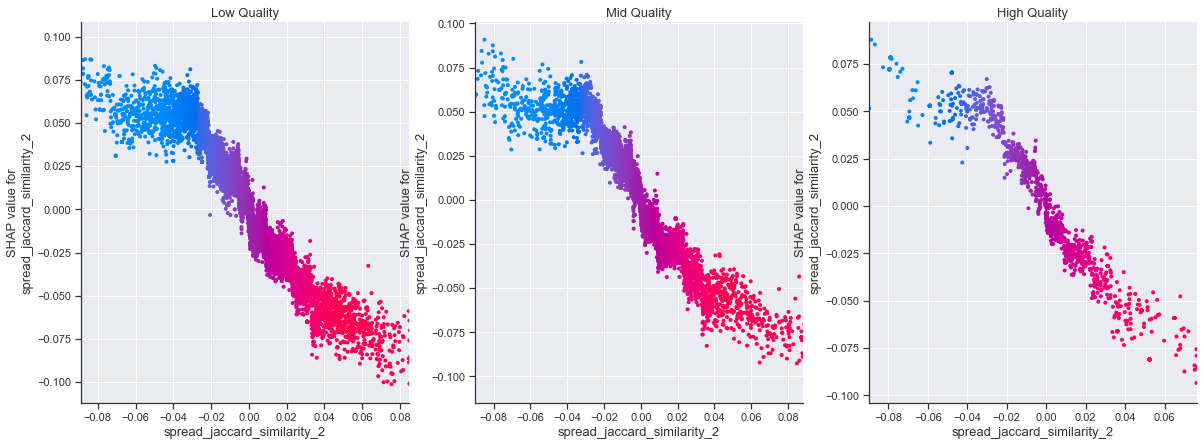

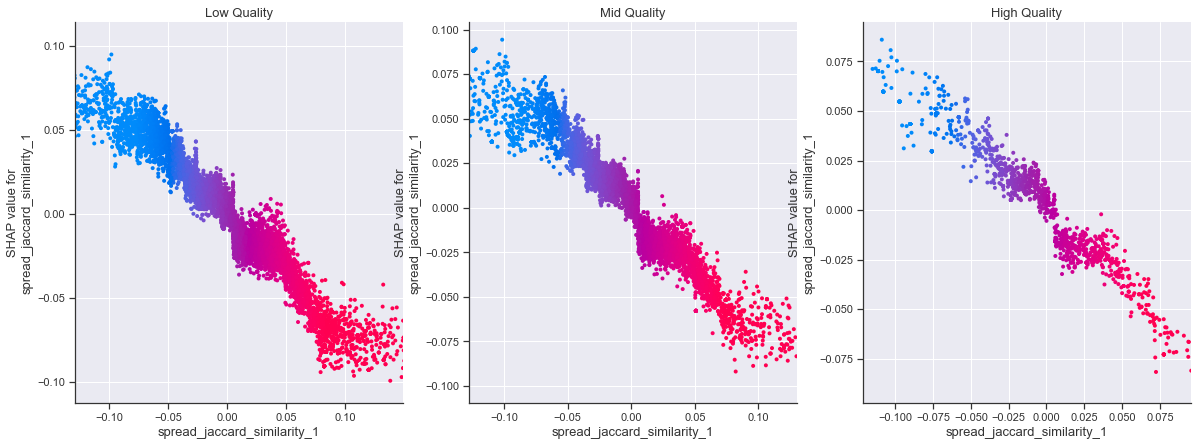

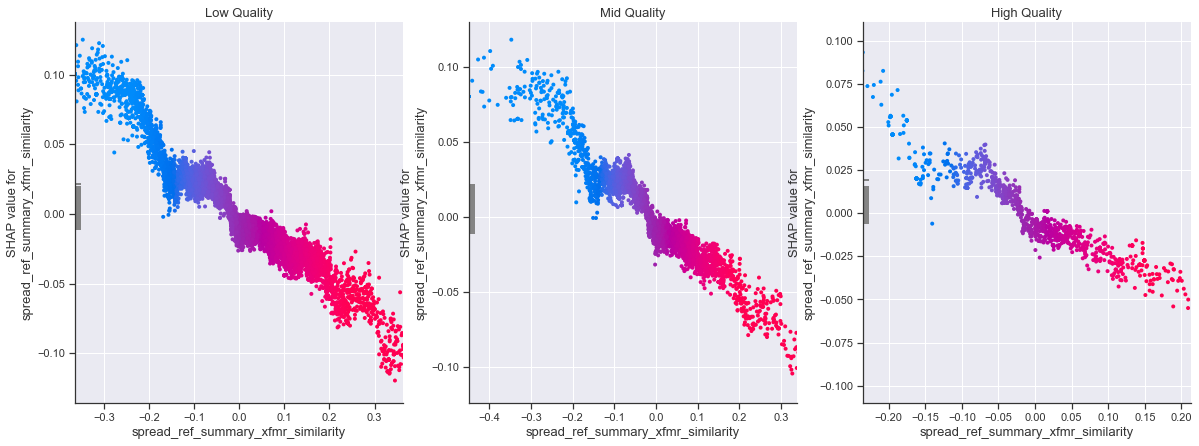

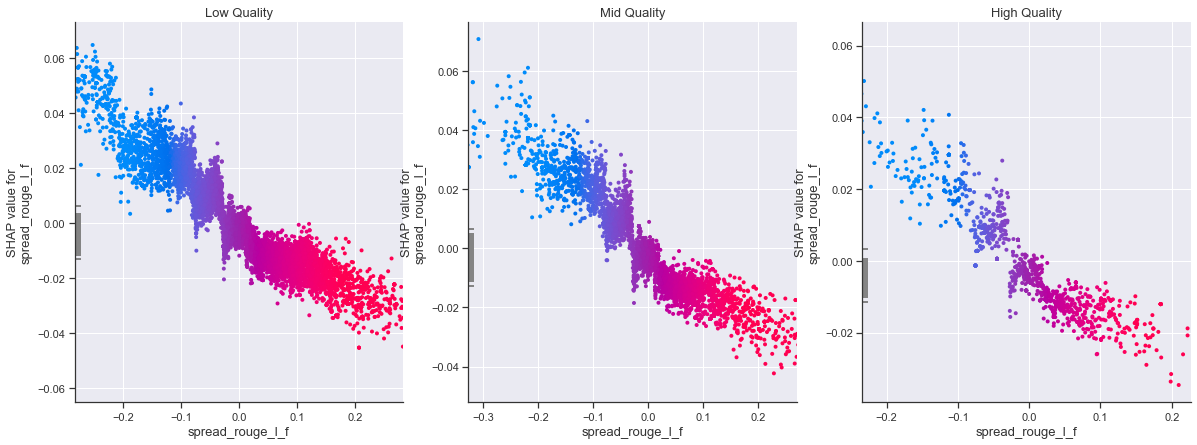

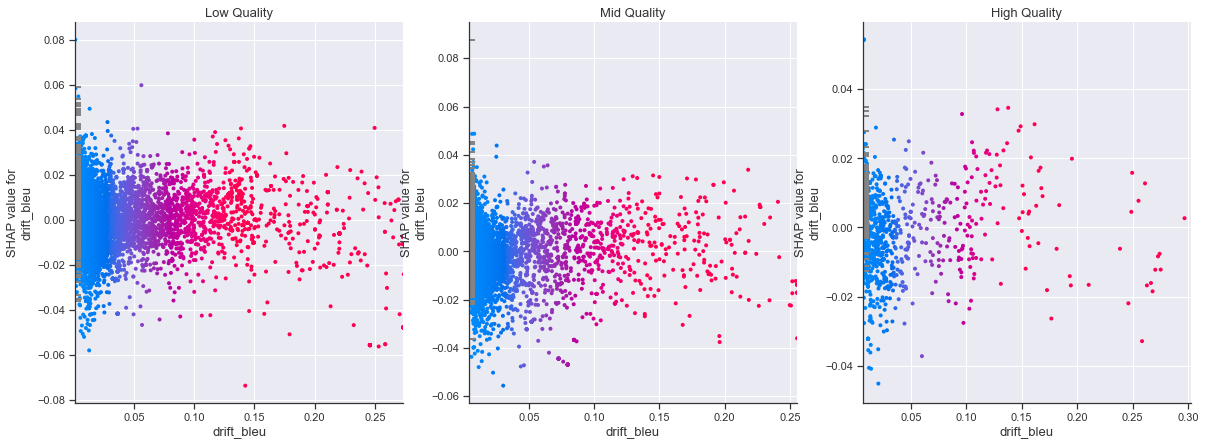

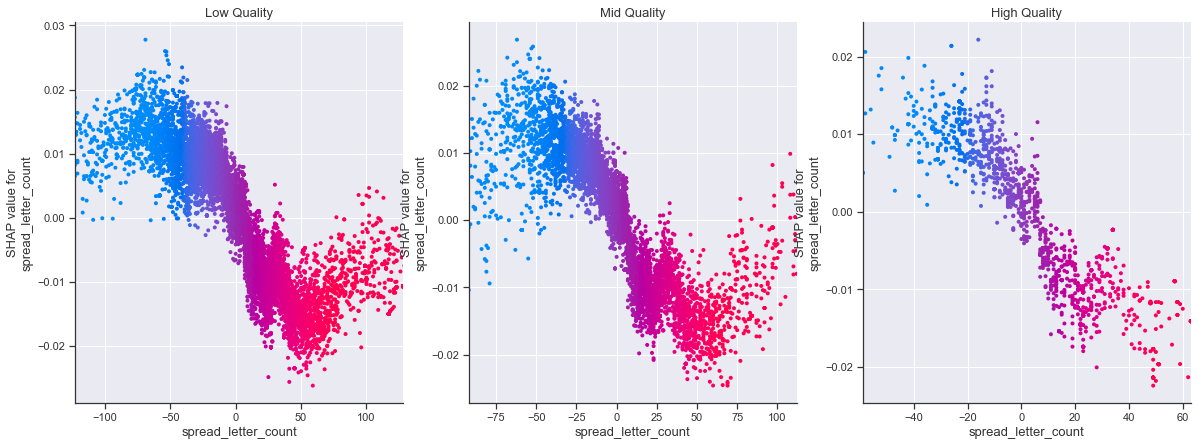

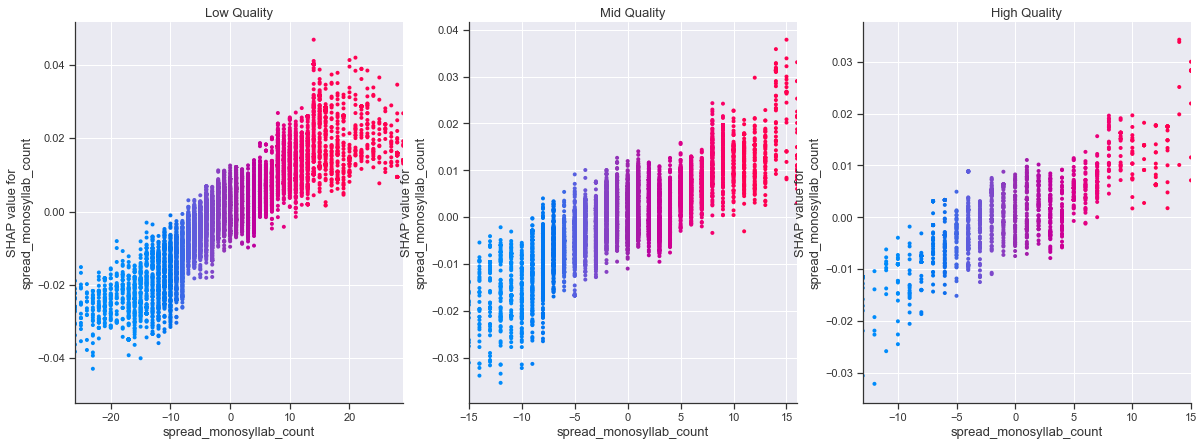

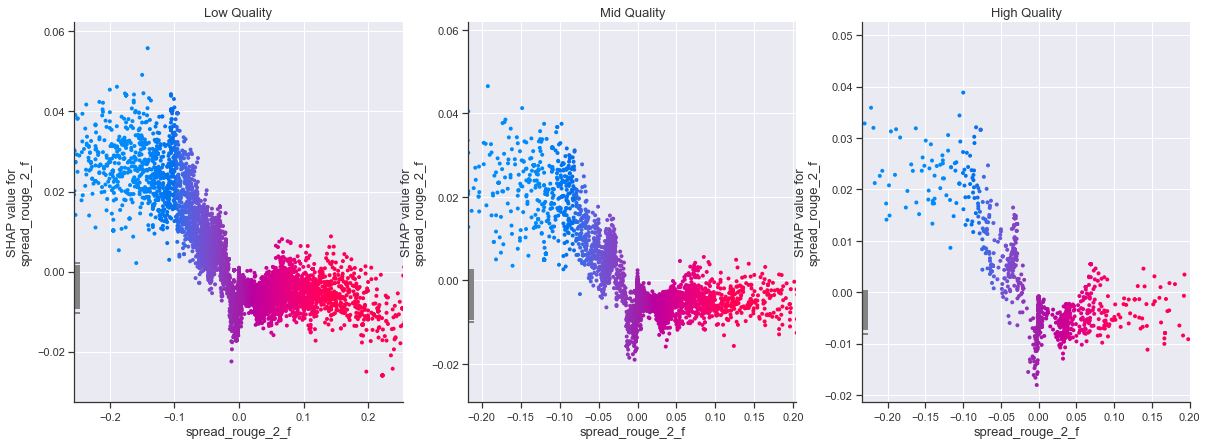

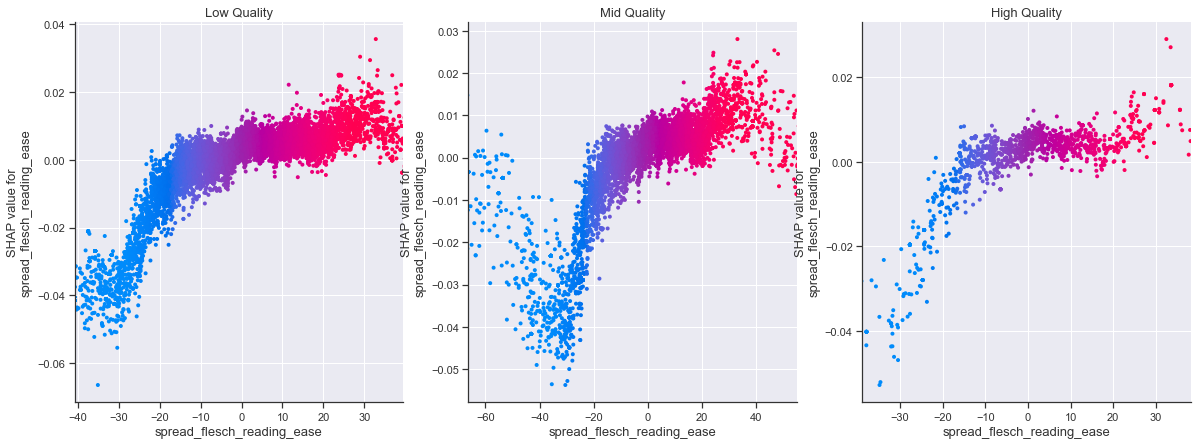

In [126]:
for topk in shap_df.iloc[::-1].index[:10]:

    plot_shap_dependence(
        metric=topk, 
        X_low=SummXAI_low.X_test, 
        X_medium=SummXAI_medium.X_test, 
        X_high=SummXAI_high.X_test, 
        shap_values_low=shap_values_low.values, 
        shap_values_medium=shap_values_medium.values, 
        shap_values_high=shap_values_high.values,
    )
